# 인물 사진 만들어보기 프로젝트

시작하기 앞서 사용할 폴더를 만듭니다.


``` terminal
$ mkdir -p ~/aiffel/human_segmentation/models
$ mkdir -p ~/aiffel/human_segmentation/images
```



사용할 library를 불러옵니다.

In [192]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

# 모델 준비하기 

[DeepLab Demo 링크](https://github.com/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb)

In [193]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

### 사전학습된 가중치 불러오기 

구글이 제공하는 deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight을 다운로드 받고                 
DeepLabModel 을 초기화합니다. 이 모델은 PASCAL VOC 2012라는 대형 데이터셋으로 학습된 v3 버전입니다.

다양한 데이터셋과 백본(backbone) 모델에 대한 pretrained weight은 [여기](https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/model_zoo.md)에서 확인할 수 있습니다.



In [194]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/ssac4/aiffel/human_segmentation/models
model loaded successfully!


# 이미지 불러오기

In [195]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/car_bike_person.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)
print(img_path)

(1200, 1444, 3)
/home/ssac4/aiffel/human_segmentation/images/car_bike_person.jpg


<div style="width:48%; height:48%; float:left; margin-right:10px;">
<img src="./../aiffel/human_segmentation/images/car_bike_person.jpg">
</div>


In [196]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1200, 1444, 3) (426, 513, 3) 15


In [197]:
np.histogram(seg_map,bins = range(0,16))

(array([118880,      0,  16136,      0,      0,      0,      0,  57819,
             0,      0,      0,      0,      0,      0,  25703]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]))

seg_map을 보면 0이 118880개, 2가 16136개 7이 57819개 15가 25703개임을 확인할 수 있습니다.

In [199]:
a = np.histogram(seg_map,bins = range(0,16))
print(a[0])
print(a[1])

[118880      0  16136      0      0      0      0  57819      0      0
      0      0      0      0  25703]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


0~15의 의미는 아래와 같습니다.

In [200]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

즉 background가  118880개, bicycle이 16136개, car가 57819개, person이 25703개 픽셀에서 인식된것입니다.

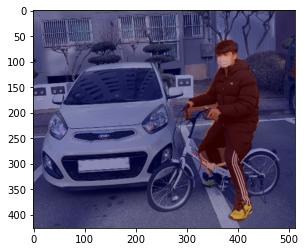

In [201]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

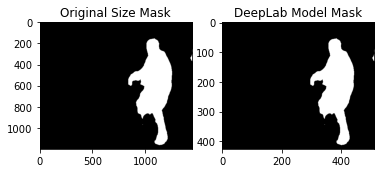

In [202]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

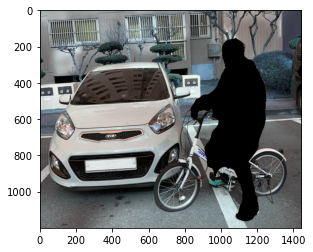

In [203]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

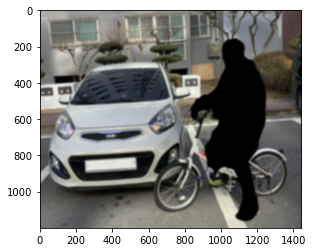

In [204]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

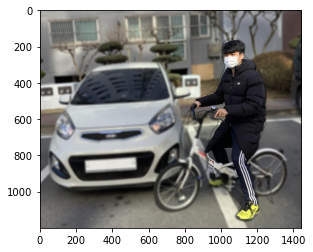

In [205]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [88]:
cv2.imwrite('figure_mode.jpg',img_concat )

True



# 변형하기 

사람이 아닌 다른 물건에 대한 아웃 포커싱 사진도 만들어 보겠습니다.

배경 사진을 다른 이미지로 교체하는 크로마키 배경 합성을 해봅니다. 

In [206]:
pot_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/pottedplant.jpg'
bike_path = os.getenv('HOME') +'/aiffel/human_segmentation/images/bike_person.jpg'
car_bike_person = os.getenv('HOME') +'/aiffel/human_segmentation/images/car_bike_person.jpg'

# pottedplant 인식

In [207]:
pot_img_orig = cv2.imread(pot_path)
print (pot_img_orig.shape)


(4032, 3024, 3)


In [208]:
img_pot_resized, pot_seg_map = MODEL.run(pot_img_orig)
print (pot_img_orig.shape, img_pot_resized.shape, pot_seg_map.max())


(4032, 3024, 3) (513, 384, 3) 16


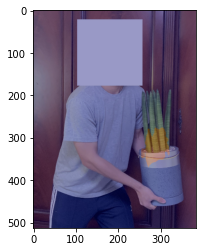

In [209]:
pot_img_show = img_pot_resized.copy()
pot_seg_map  = np.where(pot_seg_map  == 16, 16, 0) # 예측 중 사람만 추출
pot_img_mask = pot_seg_map  * (255/pot_seg_map.max()) # 255 normalization
pot_img_mask = pot_img_mask.astype(np.uint8)
pot_color_mask = cv2.applyColorMap(pot_img_mask, cv2.COLORMAP_JET)
pot_img_show = cv2.addWeighted(pot_img_show, 0.6, pot_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(pot_img_show, cv2.COLOR_BGR2RGB))
plt.show()

안타깝게도 pottedplant의 일부만 인식하는 것을 확인할 수 있었습니다.

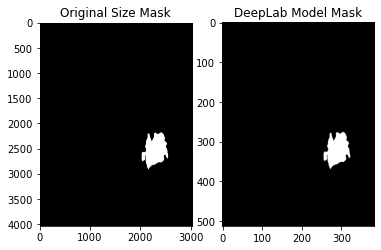

In [210]:
pot_img_mask_up = cv2.resize(pot_img_mask, pot_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, pot_img_mask_up = cv2.threshold(pot_img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(pot_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(pot_img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

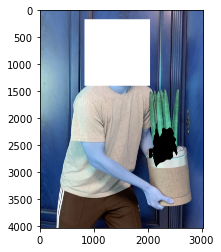

In [211]:
pot_img_mask_color = cv2.cvtColor(pot_img_mask_up, cv2.COLOR_GRAY2BGR)
pot_img_bg_mask = cv2.bitwise_not(pot_img_mask_color)
pot_img_bg = cv2.bitwise_and(pot_img_orig, pot_img_bg_mask)
plt.imshow(pot_img_bg)
plt.show()

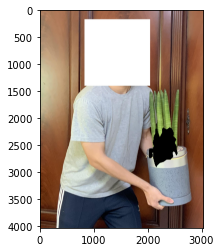

In [212]:
pot_img_bg_blur = cv2.blur(pot_img_bg, (13,13))
plt.imshow(cv2.cvtColor(pot_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

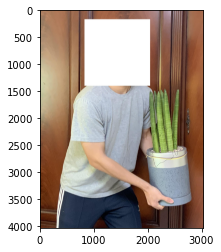

In [213]:
pot_img_concat = np.where(pot_img_mask_color==255, pot_img_orig, pot_img_bg_blur)
plt.imshow(cv2.cvtColor(pot_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [214]:
cv2.imwrite('pot_figure_mode.jpg',pot_img_concat )

True

## bike와 사람을 따로 인식 후 배경 합성

In [215]:
bike_path = os.getenv('HOME') +'/aiffel/human_segmentation/images/bike_person.jpg'
bike_img_orig = cv2.imread(bike_path)

print (bike_img_orig.shape)


(1200, 939, 3)


In [216]:
bike_img_resized, bike_seg_map = MODEL.run(bike_img_orig)
print (bike_img_orig.shape, bike_img_resized.shape, bike_seg_map.max())

(1200, 939, 3) (513, 401, 3) 15


In [217]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

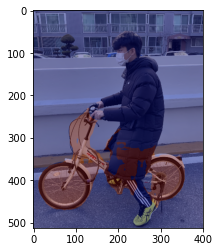

In [218]:
bike_b_img_show = bike_img_resized.copy()
bike_b_seg_map = np.where(bike_seg_map == 2, 2, 0) # 예측 중 사람만 추출
bike_b_img_mask = bike_b_seg_map * (255/bike_b_seg_map.max()) # 255 normalization
bike_b_img_mask = bike_b_img_mask.astype(np.uint8)
bike_b_color_mask = cv2.applyColorMap(bike_b_img_mask, cv2.COLORMAP_JET)
bike_b_img_show = cv2.addWeighted(bike_img_show, 0.6, bike_b_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(bike_b_img_show, cv2.COLOR_BGR2RGB))
plt.show()

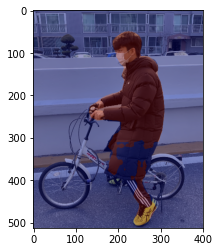

In [219]:
bike_img_show = bike_img_resized.copy()
bike_seg_map = np.where(bike_seg_map == 15, 15, 0) # 예측 중 사람만 추출
bike_img_mask = bike_seg_map * (255/bike_seg_map.max()) # 255 normalization
bike_img_mask = bike_img_mask.astype(np.uint8)
bike_color_mask = cv2.applyColorMap(bike_img_mask, cv2.COLORMAP_JET)
bike_h_img_show = cv2.addWeighted(bike_img_show, 0.6, bike_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(bike_h_img_show, cv2.COLOR_BGR2RGB))
plt.show()

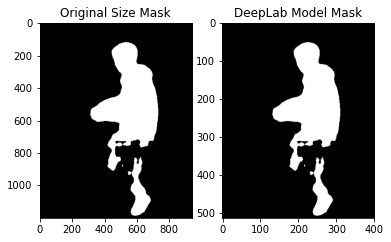

In [220]:
bike_img_mask_up = cv2.resize(bike_img_mask, bike_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, bike_img_mask_up = cv2.threshold(bike_img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(bike_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(bike_img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

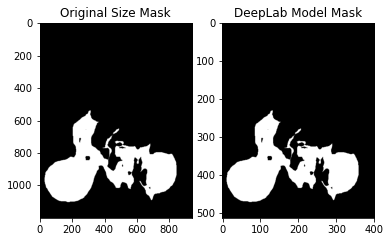

In [221]:
bike_b_img_mask_up = cv2.resize(bike_b_img_mask, bike_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, bike_b_img_mask_up = cv2.threshold(bike_b_img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(bike_b_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)

plt.imshow(bike_b_img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

# 배경이미지 불러오기 

In [222]:
back_path = os.getenv('HOME') +'/aiffel/human_segmentation/images/background.jpg'
back_img_orig = cv2.imread(back_path)


In [223]:
back_img_resized, back_seg_map = MODEL.run(back_img_orig)
print (back_img_orig.shape, back_img_resized.shape, back_seg_map.max())

(1200, 939, 3) (513, 401, 3) 15


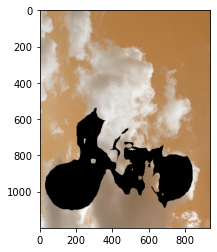

In [224]:
bike_b_img_mask_color = cv2.cvtColor(bike_b_img_mask_up , cv2.COLOR_GRAY2BGR)
bike_b_img_bg_mask = cv2.bitwise_not(bike_b_img_mask_color)  #bitwise_not 이미지 반전 
plt.imshow(bike_b_img_bg_mask)

bike_b_img_bg = cv2.bitwise_and(back_img_orig, bike_b_img_bg_mask)  # 
plt.imshow(bike_b_img_bg)
plt.show()

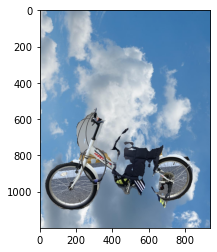

In [225]:
img_concat = np.where(bike_b_img_mask_color==255, bike_img_orig, bike_b_img_bg)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

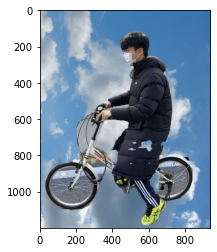

In [226]:
img_concat1 = np.where(bike_h_img_mask_color==0, img_concat, bike_img_orig)
plt.imshow(cv2.cvtColor(img_concat1, cv2.COLOR_BGR2RGB))
plt.show()

In [230]:
cv2.imwrite('Chroma Key.jpg',img_concat1)

True

합성에 성공했습니다.

# 문제점 찾기 

In [227]:
problem_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/figure_mode_p.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_problem = cv2.imread(problem_path) 

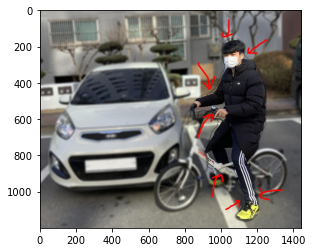

In [228]:
plt.imshow(cv2.cvtColor(img_problem, cv2.COLOR_BGR2RGB))
plt.show()

<div style="width:48%; height:48%; float:left; margin-right:10px;">
<img src="./pot_figure_mode_pp.jpg">
</div>
<div style="width:48%; height:48%; float:left;">
<img src="../aiffel/human_segmentation/images/figure_mode_p.jpg">
</div>

<div style="width:48%; height:48%; float:left;">
<img src="./Chroma Key.jpg">
</div>

1. 전체적으로 경계 부분이 깔끔하게 인지되지않음을 확인할 수 있었습니다.

2. 전체를 인식하지못하고 일부분만 인식하는 것을 확인할 수 있었습니다.

# 해결방법제안

어떻게 MASK 영역에 적용되어 문제점을 보완하게 되는지 메커니즘을 포함한 솔루션으로 서술하라 

* 아이디어 1. depth 정보를 활용 

* 아이디어 2. 그 우리 얼굴사진했을때처럼 자연스럽게 합성하는 스킬 써보기  


> 실제 사진의 아웃 포커싱 원리
>
> 피사체에 촛점을 맞추면. 피사체에 촛점을 맞춘 빛이 영사됨. 이때 피사체는 필름에 정확하게 촛점을 맞춘 것이 영사됨.           
> 하지만 피사체와 **거리가 있는 배경들은 필름에 촛점을 맞추지못하고 영사됨**. 그러므로 주변 배경은 흐릿하게 표현됨                  
               
<div style="width:48%; height:48%;">
<img src="./me.PNG">
</div>










                                                
                                                           
                                                                   
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                               
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                           
























                             
                         
                           
              

우리는 사진의 의미는 잘 파악하고 있지만 경계선을 제대로 파악하지 못하는 문제가 있습니다.             
segmentation을 통해 일단 물체를 파악한 뒤, depth 정보를 이용하여 같은 depth인 부분을 한 물체로 인식한다면       

인물사진에서 depth 정보를 통해 추가적인 분리가 가능하여 더 깔끔하게 아웃포커싱 가능할것 같습니다.

dept 정보는 여러 카메라를 이용한 

1. 3D depth Camera를 활용하거나 
[참고자료](https://m.blog.naver.com/panoptics/221336152952)

2. Struct2Dept라는 기법을 사용하여 depth 정보를 파악하거나
[참고자료](https://sites.google.com/view/struct2depth)

3. IR 적외선을 활용하여 파악할수 있을것 같습니다.
[참고자료](https://ai.googleblog.com/2020/04/udepth-real-time-3d-depth-sensing-on.html)

실제 구글의 픽셀4는 segmentaion와 Deth를 함께 사용하여 인식을 한다고 합니다.

![이미지](https://1.bp.blogspot.com/-_tX5N2eCoiU/Xo-5SxlpIZI/AAAAAAAAFqU/8CCuwX0w0hE2i9s8fTJRXU0KdcpnGet5wCLcBGAsYHQ/s640/image8.png)

# 소고

image segmetaion 자체는 놀랄만한 정확도를 보여줘서 깜짝 놀랐습니다. 경계가 다소 애매하긴 해도 

놀랄만큼 잡아주는것 같습니다. 

반면 이미지에 대해 후처리를 하는것은 

개념이 부족해서 시행착오를 겪다가   

한번 딱 성공하면 거기서 지쳐버리는것같습니다. 뭔가 좀 더 기초적으로 배우면 좋을 것 같습니다. 

문제점을 해결할 방안을 정리한다는게 익숙치않아서 어려웠습니다.
